<a href="https://colab.research.google.com/github/Luffyapo93/Pool/blob/main/Examen_practico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# ===============================
# 1. Importación de librerías
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Procesamiento de lenguaje natural
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


In [19]:
# ===============================
# 2. Preprocesamiento de datos
# ===============================
def preprocess_data(file_path):
    """
    Carga un CSV financiero, limpia datos nulos,
    normaliza el precio 'close' y genera nuevas variables.
    """
    df = pd.read_csv(file_path, sep=",", header=0)
    df.columns = df.columns.str.strip()  # Limpia espacios en nombres

    # Confirmar que existe la columna correcta
    if "close" not in df.columns:
        print("⚠️ Columnas disponibles:", df.columns)
        raise KeyError("No se encontró la columna 'close'. Revisa el CSV.")

    df = df.dropna()

    # Normalización
    scaler = StandardScaler()
    df['close'] = scaler.fit_transform(df[['close']])

    # Variables adicionales
    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['Volatility'] = df['close'].rolling(window=20).std()

    df = df.dropna()
    return df

In [20]:
# ===============================
# 3. Análisis Exploratorio
# ===============================
def perform_eda(df):
    print("📊 Estadísticas descriptivas:")
    print(df.describe())

    # Histograma
    plt.figure(figsize=(10,5))
    sns.histplot(df['close'], bins=30, kde=True)
    plt.title("Distribución de precios de cierre (normalizados)")
    plt.show()

    # Serie temporal con media móvil
    plt.figure(figsize=(12,6))
    plt.plot(df['date'], df['close'], label="Precio Normalizado")
    plt.plot(df['date'], df['SMA_20'], label="Media Móvil 20d")
    plt.title("Precio vs Media Móvil")
    plt.legend()
    plt.show()


In [21]:
# ===============================
# 4. Machine Learning
# ===============================
def train_ml_model(df):
    """
    Entrena un modelo ML (ejemplo: Regresión Logística)
    para predecir la tendencia (sube/baja).
    """
    X = df[['close', 'SMA_20', 'Volatility']]
    y = (df['close'].shift(-1) > df['close']).astype(int)
    X, y = X[:-1], y[:-1]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = LogisticRegression()
    # model = RandomForestClassifier()  # alternativa

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("✅ Resultados del modelo ML:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred))

    return model


In [22]:
# ===============================
# 5. NLP (Análisis de Sentimiento)
# ===============================
def analyze_sentiment(texts):
    nltk.download("vader_lexicon")
    sia = SentimentIntensityAnalyzer()

    results = []
    for t in texts:
        score = sia.polarity_scores(t)
        results.append({"Texto": t, "Sentimiento": score})

    return results


In [23]:
# ===============================
# 6. Deep Learning (LSTM)
# ===============================
def build_lstm(df):
    data = df[['close']].values
    time_steps = 10

    # Crear secuencias
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    X, y = np.array(X), np.array(y)

    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = Sequential([
        LSTM(50, activation='relu', input_shape=(time_steps, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print("✅ Evaluación LSTM:")
    print("RMSE:", rmse)
    print("MAPE:", mape)

    plt.figure(figsize=(12,6))
    plt.plot(y_test, label="Real")
    plt.plot(y_pred, label="Predicción")
    plt.title("Predicción con LSTM")
    plt.legend()
    plt.show()

    return model


📊 Estadísticas descriptivas:
             ranknow          open  ...         SMA_20    Volatility
count  942278.000000  9.422780e+05  ...  942278.000000  9.422780e+05
mean     1000.190755  3.483568e+02  ...      -0.000018  7.920586e-03
std       587.564077  1.318449e+04  ...       0.933692  3.672746e-01
min         1.000000  2.500000e-09  ...      -0.026424  0.000000e+00
25%       465.000000  2.321000e-03  ...      -0.026423  0.000000e+00
50%      1072.000000  2.398000e-02  ...      -0.026422  3.347780e-07
75%      1484.000000  2.268007e-01  ...      -0.026406  3.078252e-06
max      2072.000000  2.298390e+06  ...      78.601409  5.952329e+01

[8 rows x 11 columns]


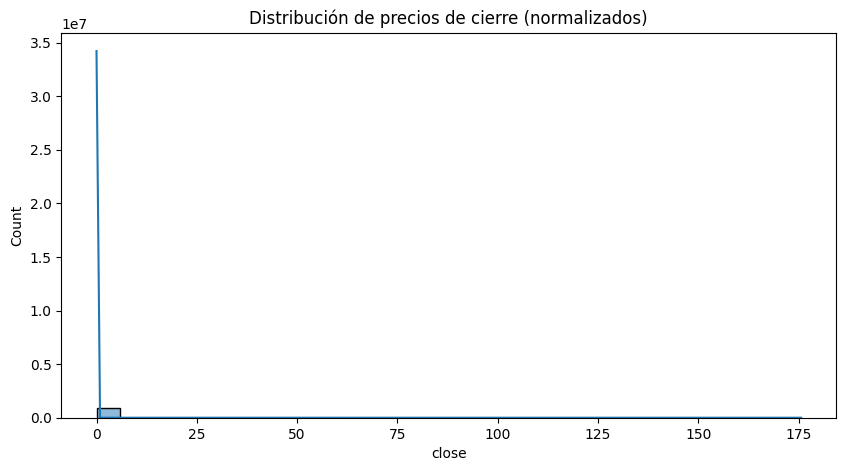

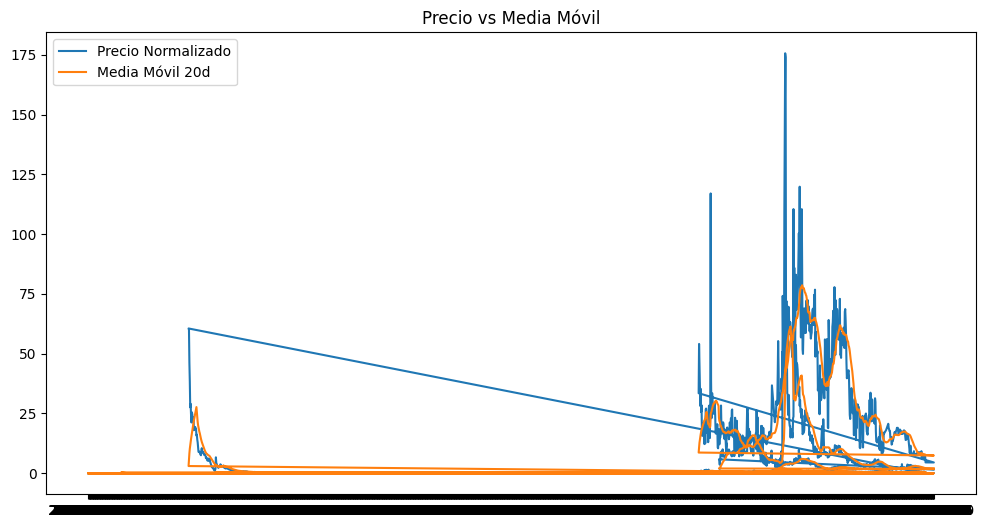

✅ Resultados del modelo ML:
Accuracy: 0.5446523326399796
F1-score: 0.00020971443883911406
ROC-AUC: 0.5000183389509484


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


[{'Texto': 'El mercado está en alza', 'Sentimiento': {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}}, {'Texto': 'Se espera una caída fuerte en las criptomonedas', 'Sentimiento': {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}}]


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
47114/47114 ━━━━━━━━━━━━━━━━━━━━ 240s 5ms/step - loss: 6.1191e-05
Epoch 2/10
47114/47114 ━━━━━━━━━━━━━━━━━━━━ 237s 5ms/step - loss: 3.5736e-05
Epoch 3/10
47114/47114 ━━━━━━━━━━━━━━━━━━━━ 264s 5ms/step - loss: 2.3790e-05
Epoch 4/10
47114/47114 ━━━━━━━━━━━━━━━━━━━━ 260s 5ms/step - loss: 1.8903e-05
Epoch 5/10
47114/47114 ━━━━━━━━━━━━━━━━━━━━ 269s 5ms/step - loss: 1.4341e-05
Epoch 6/10
47114/47114 ━━━━━━━━━━━━━━━━━━━━ 262s 5ms/step - loss: 1.6759e-05
Epoch 7/10
47114/47114 ━━━━━━━━━━━━━━━━━━━━ 264s 5ms/step - loss: 2.2075e-05
Epoch 8/10
47114/47114 ━━━━━━━━━━━━━━━━━━━━ 260s 5ms/step - loss: 1.7134e-05
Epoch 9/10
47114/47114 ━━━━━━━━━━━━━━━━━━━━ 224s 5ms/step - loss: 2.7403e-05
Epoch 10/10
47114/47114 ━━━━━━━━━━━━━━━━━━━━ 258s 5ms/step - loss: 1.7442e-05
5890/5890 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
✅ Evaluación LSTM:
RMSE: 2.1245389770270067
MAPE: 0.02263078894169294


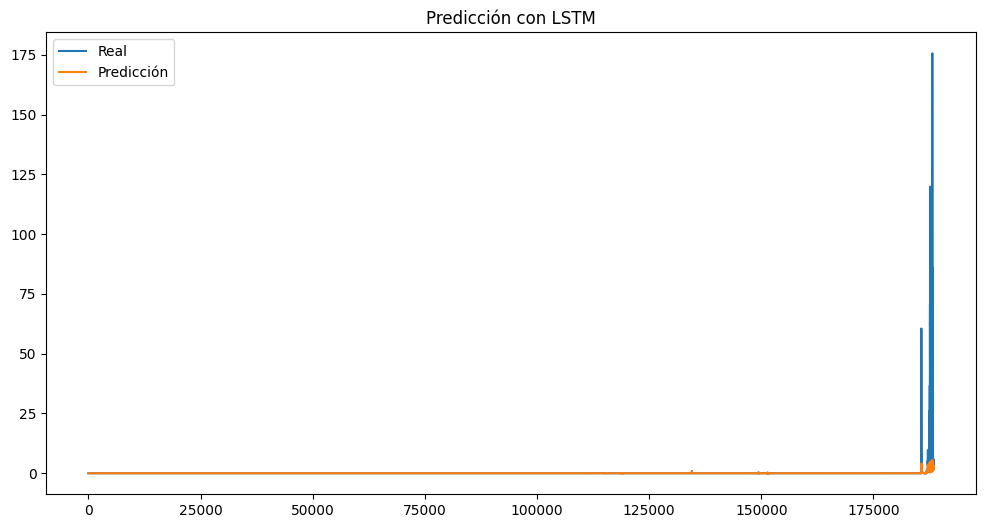

In [24]:
# ===============================
# 7. Ejemplo de uso
# ===============================
if __name__ == "__main__":
    file_path = "/content/crypto-markets.csv"

    # 1. Preprocesamiento
    df = preprocess_data(file_path)

    # 2. EDA
    perform_eda(df)

    # 3. ML
    ml_model = train_ml_model(df)

    # 4. NLP
    textos = ["El mercado está en alza", "Se espera una caída fuerte en las criptomonedas"]
    resultados_nlp = analyze_sentiment(textos)
    print(resultados_nlp)

    # 5. LSTM
    lstm_model = build_lstm(df)
